# **Data Preparation**

In [1]:
# basic ml packages
import numpy as np
from numpy import expand_dims
import pandas as pd
import json

In [2]:
# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
# Sklearn and Tensorflow Classes
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
import keras
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, RandomFlip
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [128]:
# Load Utilities
import importlib
import project_utilities as util
importlib.reload(util)

<module 'project_utilities' from '/Users/lincolnrychecky/Desktop/AppliedMachineLearning/FinalProject/project_utilities.py'>

In [5]:
# Open Dataset. We will be using the json which contains data, label, location coords, and scene ids. The Data is stored
# in row major order with 19200 data points split into thirds with red, green, and then blue appearing in that order.
with open('archive/shipsnet.json') as data_file:
    dataset = json.load(data_file)

shipsnet= pd.DataFrame(dataset)
shipsnet.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [6]:
shipsnet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       4000 non-null   object
 1   labels     4000 non-null   int64 
 2   locations  4000 non-null   object
 3   scene_ids  4000 non-null   object
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


In [7]:
# 25% of the data represents the positive class (a full ship)
shipsnet.describe()

,labels
count,4000.000000
mean,0.250000
std,0.433067
min,0.000000
25%,0.000000
50%,0.000000
75%,0.250000
max,1.000000


In [8]:
# data and labels are the only two data points that interest us. Coords and planet scene Id are unimportant
shipsnet = shipsnet[["data", "labels"]]
# pixel data is an 80x80 RGB image. It is stored as a list of 19200 ints with the first 6400 entries being red channel,
# the next 64000 green channel, and the last 6400 blue channel.

In [9]:
labelCounts = shipsnet["labels"].value_counts()

ships = labelCounts[0]
noShips = labelCounts[1]
print("Count Ship images: " + str(ships))
print("Count non-Ship images: " + str(noShips))

Count Ship images: 3000
Count non-Ship images: 1000


In [10]:
# Convert JSON to numpy array
X = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')

In [11]:
# 4000 rows, 19200 data points per row
X.shape

(4000, 19200)

In [12]:
# three lists of 80x80 pixels. This way we have the R, G, and B images each containd in separate lists 
Xshaped = X.reshape([-1, 3, 80, 80])
Xshaped.shape

(4000, 3, 80, 80)

In [13]:
# now by transposing we get the RGB for each pixel for the entire 80x80 grid of each image
Xshaped = Xshaped.transpose([0,2,3,1])
Xshaped.shape

(4000, 80, 80, 3)

In [14]:
# now we normalize the RGB values
Xshaped = Xshaped / 255

In [15]:
# the to_categorical function is from keras. Will turn a flat list of 0s and 1s into a 1 hot encoded list based on class
yShaped = to_categorical(y, num_classes=2)
yShaped

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [103]:
Xshaped[399].shape

(80, 80, 3)

# **DATA VISUALISATION**

# **PIXEL INTENSITIES**

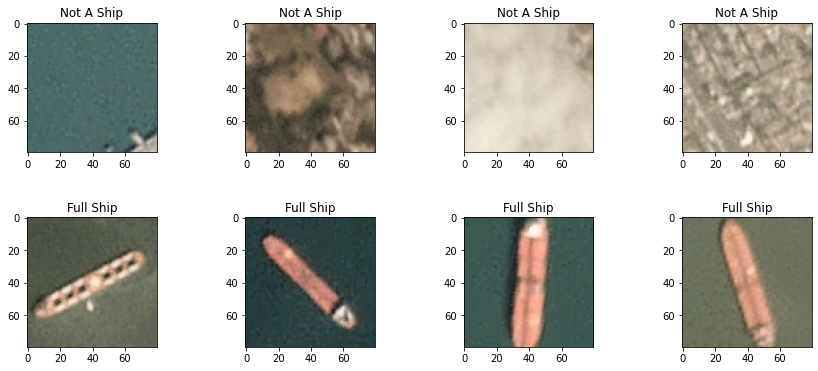

In [16]:
# Plot a few ship and non-ship images
noShipImages = Xshaped[y==0]
shipImages = Xshaped[y==1]

util.plotImages(noShipImages, shipImages)

# **PIXEL INTENSITY GRAPHS**

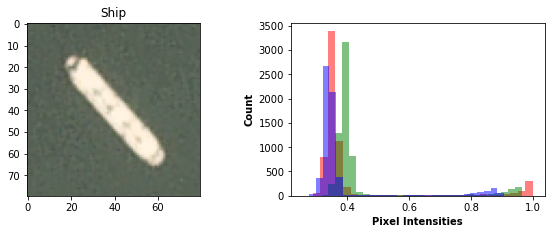

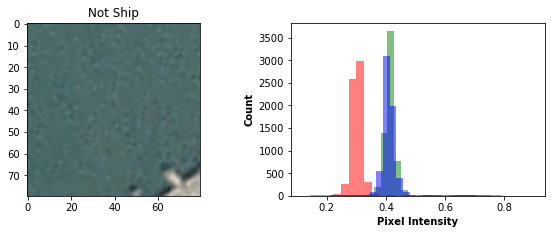

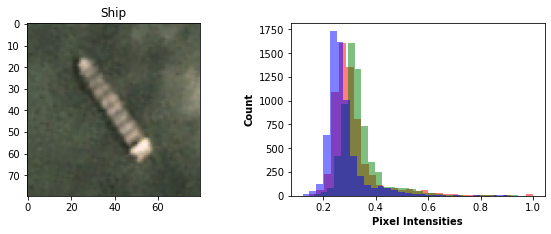

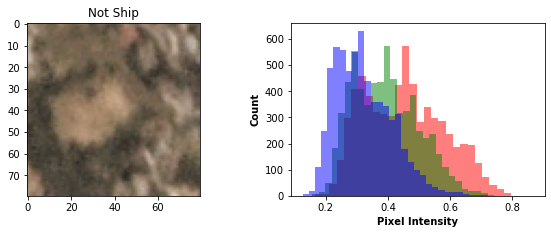

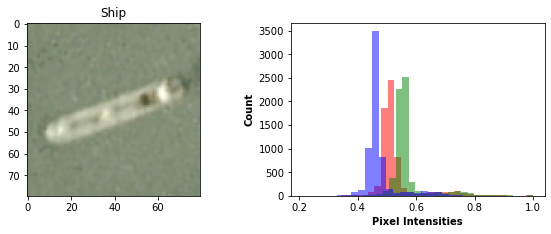

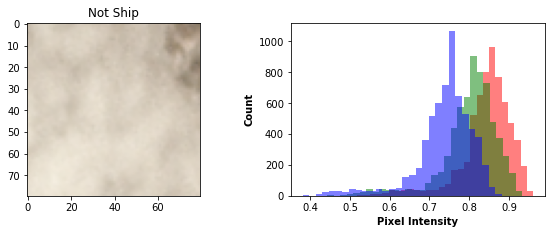

In [17]:
for i in range (0,3):
    util.plotHistogram(Xshaped[y==1][i], Xshaped[y==0][i])

# **CHANNEL VIEW**

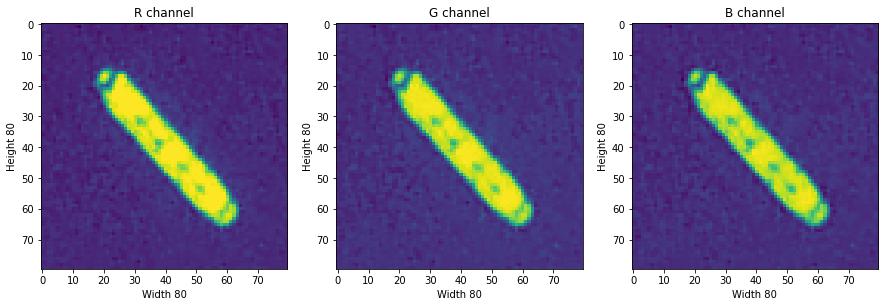

In [18]:
# plot the first ship
util.plotRGBChannels(Xshaped[y==1][0])

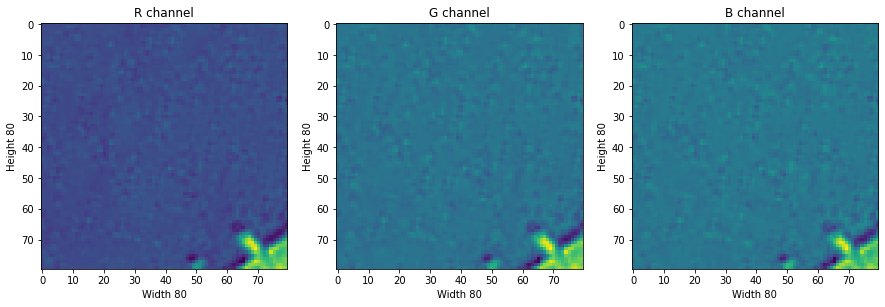

In [19]:
# plot the first non ship
util.plotRGBChannels(Xshaped[y==0][0])

# **MODELING**

## Split Datasets into Train, Validation, and Test Datasets

In [20]:
# Split to training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(Xshaped, yShaped, train_size=0.8, random_state = 11292022)
# Split the remainder into test and validation
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state = 11292022)
# 80% train, 10% test, 10% validation split

# **Standard Neural Network**

In [21]:
model = Sequential()
model.add(Flatten(input_shape=[80, 80, 3]))
model.add(Dense(200, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
                        verbose=2, mode='min', restore_best_weights=True)

history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), callbacks = [monitor])

Epoch 1/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6241 - accuracy: 0.8053 - val_loss: 0.3282 - val_accuracy: 0.8625
Epoch 2/100
100/100 [==============================] - 1s 14ms/step - loss: 0.3816 - accuracy: 0.8519 - val_loss: 0.3510 - val_accuracy: 0.8525
Epoch 3/100
100/100 [==============================] - 1s 15ms/step - loss: 0.3338 - accuracy: 0.8681 - val_loss: 0.2713 - val_accuracy: 0.8800
Epoch 4/100
100/100 [==============================] - 1s 15ms/step - loss: 0.2663 - accuracy: 0.8938 - val_loss: 0.2794 - val_accuracy: 0.8875
Epoch 5/100
100/100 [==============================] - 1s 14ms/step - loss: 0.2758 - accuracy: 0.8981 - val_loss: 0.5081 - val_accuracy: 0.8250
Epoch 6/100
100/100 [==============================] - 1s 15ms/step - loss: 0.2761 - accuracy: 0.8934 - val_loss: 0.2504 - val_accuracy: 0.8950
Epoch 7/100
100/100 [==============================] - 1s 15ms/step - loss: 0.2526 - accuracy: 0.9050 - val_loss: 0.2217 - val_accuracy:

In [22]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 4ms/step - loss: 0.1633 - accuracy: 0.9400


[0.16327808797359467, 0.9399999976158142]

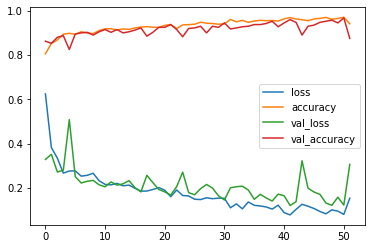

In [23]:
# plotting loss and acccracy on training and validation data
pd.DataFrame(history.history).plot();

In [24]:
history_df = pd.DataFrame(history.history)
history_df = history_df.reset_index()
history_df.head()

,index,loss,accuracy,val_loss,val_accuracy
0,0,0.624104,0.805313,0.328232,0.8625
1,1,0.381551,0.851875,0.351031,0.8525
2,2,0.333818,0.868125,0.271280,0.8800
3,3,0.266252,0.893750,0.279413,0.8875
4,4,0.275850,0.898125,0.508108,0.8250


In [25]:
history_df_long = history_df.melt(id_vars='index', 
                                value_vars=['loss', 'val_loss'])
history_df_long.columns = ['Epoch', 'Loss Type', 'Loss']
history_df_long.head()

,Epoch,Loss Type,Loss
0,0,loss,0.624104
1,1,loss,0.381551
2,2,loss,0.333818
3,3,loss,0.266252
4,4,loss,0.275850


<AxesSubplot:xlabel='Epoch', ylabel='Loss'>

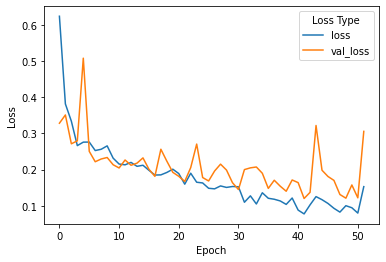

In [26]:
sb.lineplot(data=history_df_long, x='Epoch', y='Loss', hue='Loss Type')

## **Evaluate Neural Network**

13/13 [==============================] - 0s 4ms/step


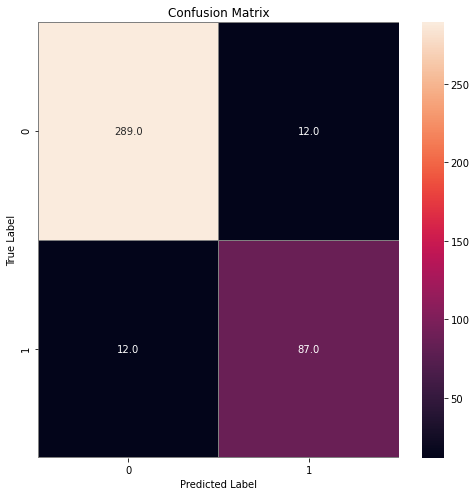

In [35]:
# Let's take a look at the confusion matrix first
util.plot_confusion(model, X_test, y_test)

In [27]:
# We will take the first predicted instance
prediction = model.predict(X_test)
pd.Series(prediction[0], index=["Not A Ship", "Ship"])

13/13 [==============================] - 0s 4ms/step


Not A Ship    0.981843
Ship          0.015872
dtype: float32

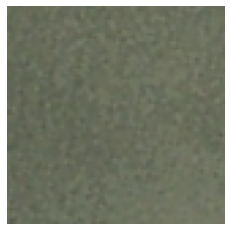

In [28]:
# now we want to plot the data point to see what the image looks like
plt.imshow(X_test[0])
plt.axis("off")
plt.show()

In [29]:
predicted_data = pd.DataFrame(prediction, columns=["Not A Ship", "Ship"])

In [30]:
y_test_data = pd.DataFrame(y_test, columns=["Not A Ship", "Ship"])

In [31]:
predicted_data['Actually Ship'] = y_test[:, 1]
predicted_data.head()

,Not A Ship,Ship,Actually Ship
0,0.981843,0.015872,0.0
1,0.937191,0.010307,0.0
2,0.797453,0.154480,0.0
3,0.984462,0.013940,0.0
4,0.998812,0.001623,0.0


In [32]:
predicted_data["Diff"] = predicted_data["Ship"] - predicted_data["Actually Ship"]

Large Diff = image was incorrectly predicted as a ship although not a ship

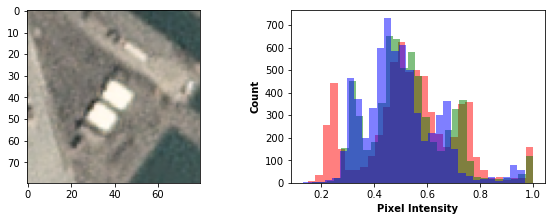

<Figure size 720x504 with 0 Axes>

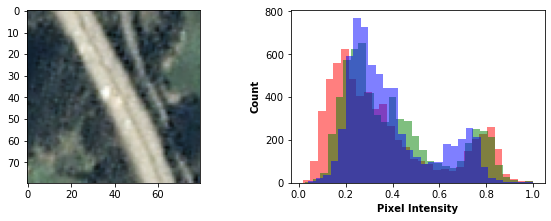

<Figure size 720x504 with 0 Axes>

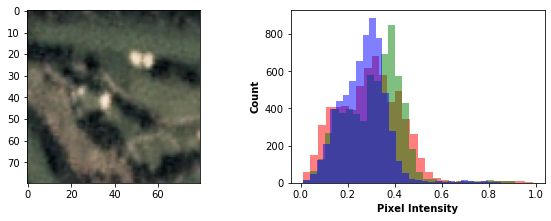

<Figure size 720x504 with 0 Axes>

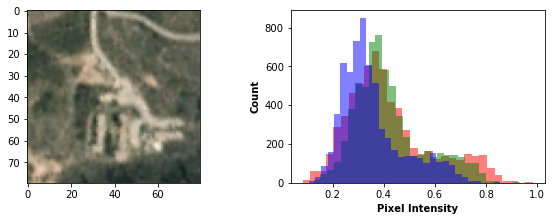

<Figure size 720x504 with 0 Axes>

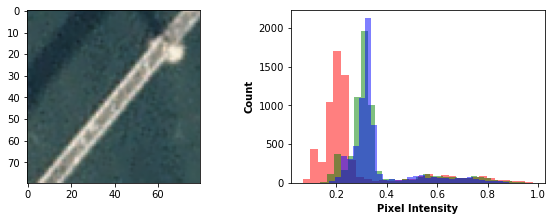

<Figure size 720x504 with 0 Axes>

In [33]:
# take the 5 "most confidently misclassified images" so we can see their visual traits
indicesDesc = predicted_data.sort_values('Diff', ascending = False).head(5).index.to_list()

for i in indicesDesc:
    util.plotSingleHistogram(X_test[i])

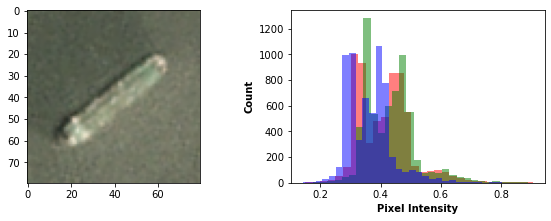

<Figure size 720x504 with 0 Axes>

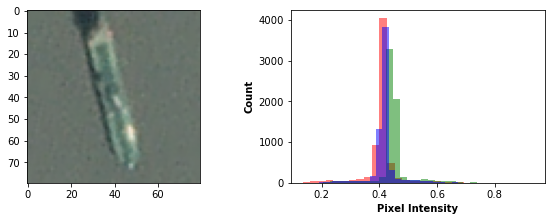

<Figure size 720x504 with 0 Axes>

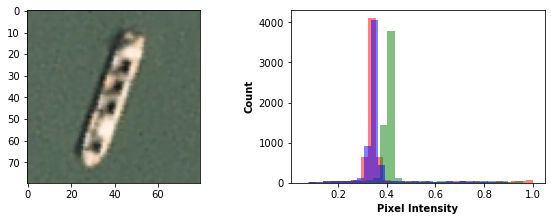

<Figure size 720x504 with 0 Axes>

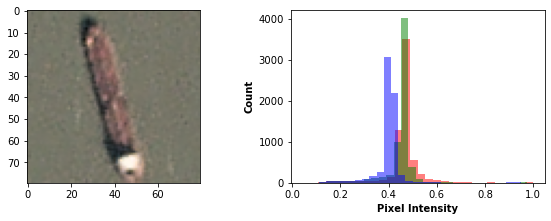

<Figure size 720x504 with 0 Axes>

In [87]:
# take the 5 "most confidently classified ship images" so we can see their visual traits
indicesAsc = predicted_data.sort_values('Diff', ascending = True).head(4).index.to_list()

for i in indicesAsc:
    util.plotSingleHistogram(X_test[i])

In [41]:
# Let's now examine the 12 ships that were misclassified as not ships
predicted_data_missclassed_ships = predicted_data[(predicted_data['Actually Ship'] == 1) & (predicted_data['Ship'] < predicted_data['Not A Ship'])]
predicted_data_missclassed_ships

,Not A Ship,Ship,Actually Ship,Diff
68,0.697786,0.187198,1.0,-0.812802
91,0.632771,0.312444,1.0,-0.687556
153,0.857783,0.081640,1.0,-0.918360
155,0.928664,0.077362,1.0,-0.922638
218,0.525703,0.368167,1.0,-0.631833
229,0.656328,0.315711,1.0,-0.684289
245,0.592895,0.217610,1.0,-0.782390
264,0.696662,0.189709,1.0,-0.810291
285,0.770777,0.190510,1.0,-0.809490
291,0.555837,0.337845,1.0,-0.662155


In [43]:
shipIndices = predicted_data_missclassed_ships.index.to_list()

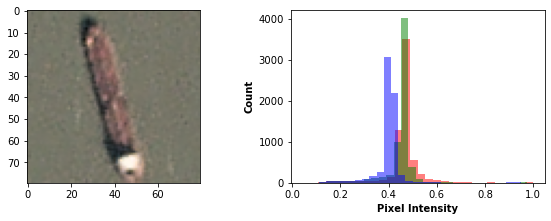

<Figure size 720x504 with 0 Axes>

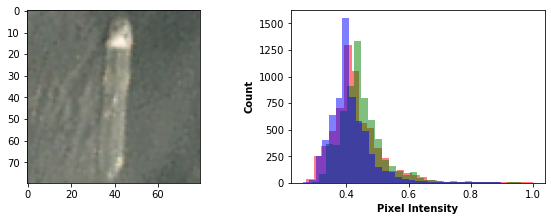

<Figure size 720x504 with 0 Axes>

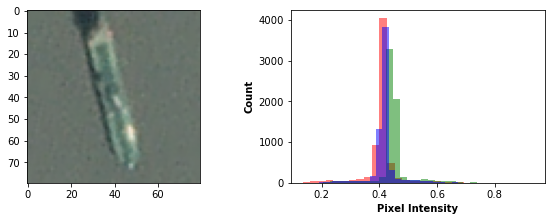

<Figure size 720x504 with 0 Axes>

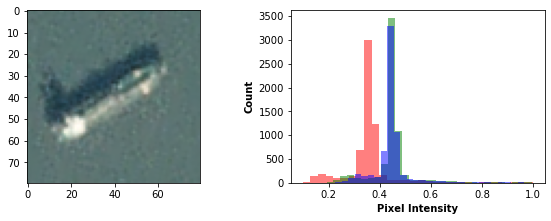

<Figure size 720x504 with 0 Axes>

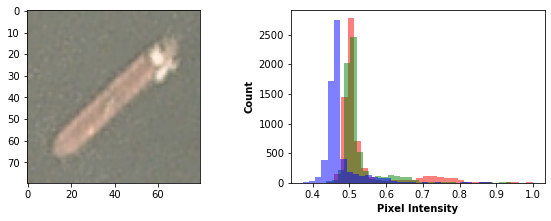

<Figure size 720x504 with 0 Axes>

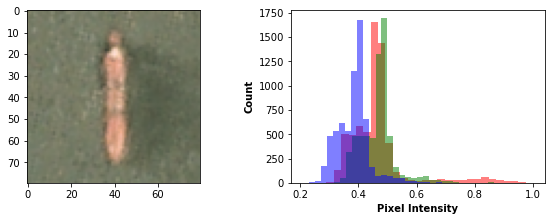

<Figure size 720x504 with 0 Axes>

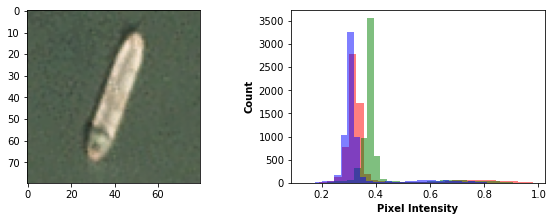

<Figure size 720x504 with 0 Axes>

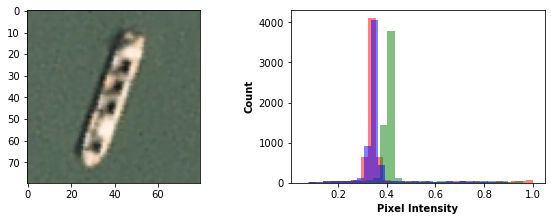

<Figure size 720x504 with 0 Axes>

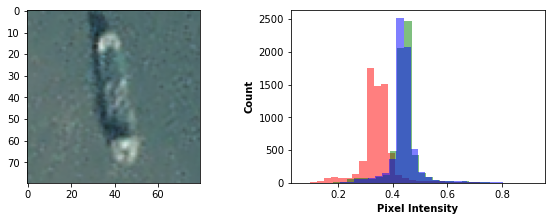

<Figure size 720x504 with 0 Axes>

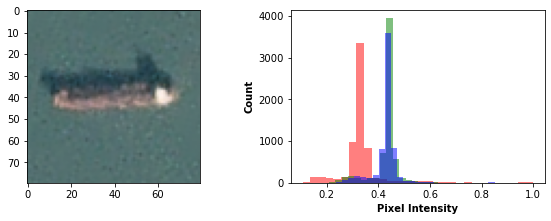

<Figure size 720x504 with 0 Axes>

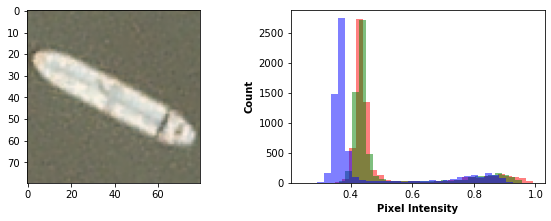

<Figure size 720x504 with 0 Axes>

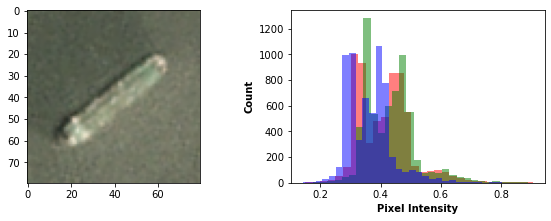

<Figure size 720x504 with 0 Axes>

In [45]:
for i in shipIndices:
    util.plotSingleHistogram(X_test[i])

## What can we learn from this?

 * Non-ship images with strongly linear featres tended to be those that were misclassified as containing a ship
 * ship images without sharp contours or softening shadows tended to be those that were miscassified as not containing a ship.
 * There is likely a degree of overfitting going on due to the gap between performance on training and validation data.

# **Convolutional Neural Network**

In [46]:
# Construct 3 layer CNN 
CNNModel = Sequential()
CNNModel.add(Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 3)))
CNNModel.add(MaxPooling2D((5,5)))
CNNModel.add(Dropout(0.5))
CNNModel.add(Conv2D(64, (3, 3), activation='relu'))
CNNModel.add(MaxPooling2D((2,2)))
CNNModel.add(Dropout(0.5))
CNNModel.add(Conv2D(64, (3, 3), activation='relu'))
CNNModel.add(Flatten())

# Now add some additional dropout layers to prevent overfitting
CNNModel.add(Dense(200, activation = "relu"))
CNNModel.add(Dropout(0.5))
CNNModel.add(Dense(100, activation = "relu"))
CNNModel.add(Dropout(0.5))
CNNModel.add(Dense(100, activation = "relu"))
CNNModel.add(Dropout(0.5))
CNNModel.add(Dense(50, activation = "relu"))
CNNModel.add(Dropout(0.5))
CNNModel.add(Dense(2, activation = "softmax"))
CNNModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 6, 6, 64)         

In [47]:
CNNModel.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
                        verbose=2, mode='auto', restore_best_weights=True)

historyCNN = CNNModel.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), callbacks = [monitor])

Epoch 1/100
100/100 [==============================] - 6s 53ms/step - loss: 0.5901 - accuracy: 0.7350 - val_loss: 0.5268 - val_accuracy: 0.7325
Epoch 2/100
100/100 [==============================] - 5s 50ms/step - loss: 0.4456 - accuracy: 0.7753 - val_loss: 0.2682 - val_accuracy: 0.9050
Epoch 3/100
100/100 [==============================] - 5s 50ms/step - loss: 0.2998 - accuracy: 0.8641 - val_loss: 0.1964 - val_accuracy: 0.9225
Epoch 4/100
100/100 [==============================] - 5s 51ms/step - loss: 0.2534 - accuracy: 0.8988 - val_loss: 0.1954 - val_accuracy: 0.9125
Epoch 5/100
100/100 [==============================] - 5s 49ms/step - loss: 0.2025 - accuracy: 0.9181 - val_loss: 0.1387 - val_accuracy: 0.9475
Epoch 6/100
100/100 [==============================] - 5s 50ms/step - loss: 0.1809 - accuracy: 0.9319 - val_loss: 0.1638 - val_accuracy: 0.9325
Epoch 7/100
100/100 [==============================] - 5s 50ms/step - loss: 0.1788 - accuracy: 0.9325 - val_loss: 0.1023 - val_accuracy:

## Evaluate CNN

In [48]:
# 98.75% accuracy on the test data. Pretty good and even better than the standard NN tested above!
CNNModel.evaluate(X_test, y_test)

13/13 [==============================] - 0s 10ms/step - loss: 0.0532 - accuracy: 0.9875


[0.05321057140827179, 0.987500011920929]

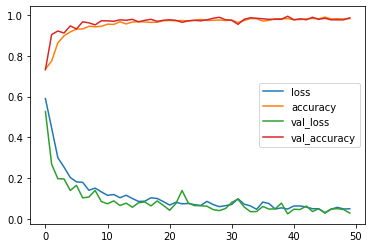

In [49]:
# Validation loss is actually less than that of the training data. This is encouraging and shows that 
# we may have avoided significant overfitting of the network.
pd.DataFrame(historyCNN.history).plot();

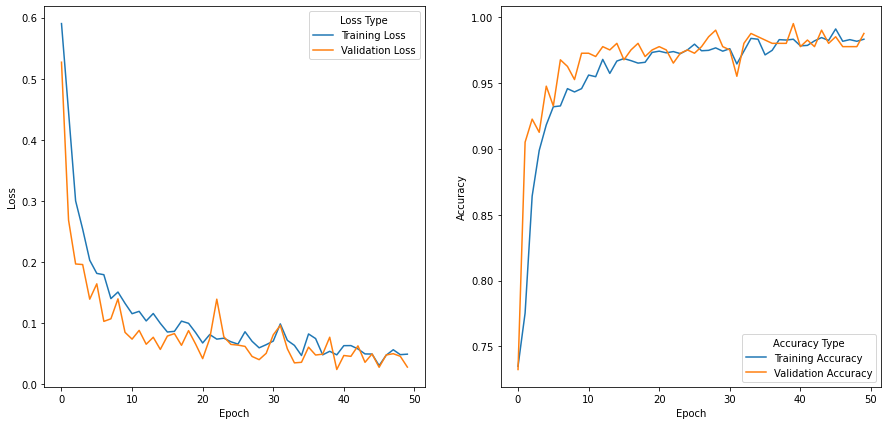

In [51]:
# based on this plot, around the 20th epoch most learning is completed.
# It is also quite interesting that the model actually performs better on the validation data 
util.plot_history(historyCNN, plot_type='both')

In [52]:
print("Test Acc Score: ",util.compute_accuracy(CNNModel, X_test, y_test))

13/13 [==============================] - 0s 10ms/step
Test Acc Score:  0.9875


13/13 [==============================] - 0s 10ms/step


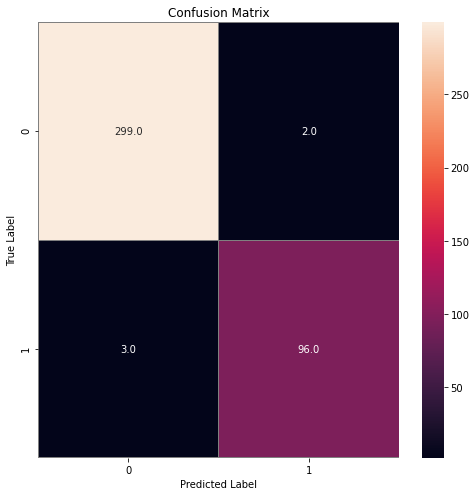

In [53]:
# Now lets take a look at the confusion matrix for the CNN
util.plot_confusion(CNNModel, X_test, y_test)

# Optimal Parameter Search

We want to do some optimal model parameter searching now. I will first compare different activation function options.

In [108]:
# Adding required libraries for grid search
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold

In [139]:
def create_model(activation='relu', dropout=0.5):
    # Construct 3 layer CNN 
    CNNModel = Sequential()
    CNNModel.add(Conv2D(32, (3, 3), activation=activation, input_shape=(80, 80, 3)))
    CNNModel.add(MaxPooling2D((5,5)))
    CNNModel.add(Dropout(dropout))
    CNNModel.add(Conv2D(64, (3, 3), activation=activation))
    CNNModel.add(MaxPooling2D((2,2)))
    CNNModel.add(Dropout(dropout))
    CNNModel.add(Conv2D(64, (3, 3), activation=activation))
    CNNModel.add(Flatten())

    # Now add some additional dropout layers to prevent overfitting
    CNNModel.add(Dense(200, activation = activation))
    CNNModel.add(Dropout(dropout))
    CNNModel.add(Dense(100, activation = activation))
    CNNModel.add(Dropout(dropout))
    CNNModel.add(Dense(100, activation = activation))
    CNNModel.add(Dropout(dropout))
    CNNModel.add(Dense(50, activation = activation))
    CNNModel.add(Dropout(dropout))
    CNNModel.add(Dense(2, activation = "softmax"))
    CNNModel.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])
    return CNNModel

mlp = KerasClassifier(build_fn=create_model, verbose=0)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [140]:
kf = KFold(n_splits=3, shuffle=True, random_state=20221203)

pipe = Pipeline(steps=[('model', mlp)])

In [141]:
activation = ['softmax', 'softplus', 'relu']

param_grid = {
    'model__activation': activation
}

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=kf, scoring='accuracy')

In [142]:
y_labels = np.argmax(yShaped, axis=1)

X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(
    Xshaped, y_labels, test_size=0.3, random_state=20221103)

In [143]:
monitor2 = EarlyStopping(monitor='loss', min_delta=1e-03, patience=5,
                         verbose=2, mode='auto', restore_best_weights=True)

In [126]:
grid_search.fit(X_train_opt, y_train_opt, model__epochs=1000, model__callbacks=[monitor2])

Restoring model weights from the end of the best epoch: 10.
Epoch 15: early stopping
30/30 [==============================] - 1s 20ms/step
Restoring model weights from the end of the best epoch: 12.
Epoch 17: early stopping
30/30 [==============================] - 1s 19ms/step
Restoring model weights from the end of the best epoch: 13.
Epoch 18: early stopping
30/30 [==============================] - 1s 24ms/step
Restoring model weights from the end of the best epoch: 22.
Epoch 27: early stopping
30/30 [==============================] - 1s 15ms/step
Restoring model weights from the end of the best epoch: 8.
Epoch 13: early stopping
30/30 [==============================] - 1s 20ms/step
Restoring model weights from the end of the best epoch: 18.
Epoch 23: early stopping
30/30 [==============================] - 1s 14ms/step
Restoring model weights from the end of the best epoch: 35.
Epoch 40: early stopping
30/30 [==============================] - 0s 12ms/step
Restoring model weights from

GridSearchCV(cv=KFold(n_splits=3, random_state=20221203, shuffle=True),
             estimator=Pipeline(steps=[('model',
                                        <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f89d9a2add0>)]),
             param_grid={'model__activation': ['softmax', 'softplus', 'relu']},
             scoring='accuracy')

,model__activation,Accuracy
0,softmax,0.747500
1,softplus,0.747500
2,relu,0.968569


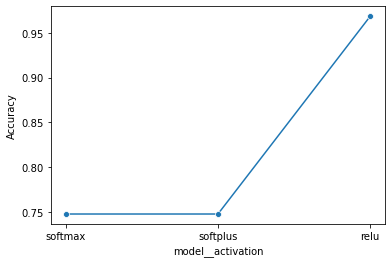

In [129]:
# Relu performs significantly better than any other tested activation function option in this case
util.plot_grid_search(grid_search)

Now we will look into dropout rate in order to see if we are optimizing our params.

In [135]:
mlp2 = KerasClassifier(build_fn=create_model, verbose=0)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [144]:
pipe2 = Pipeline(steps=[('model', mlp2)])

In [145]:
dropout = [0.0, 0.2, 0.5, 0.75, 1]
param_grid2 = {
    'model__dropout': dropout
}

grid_search2 = GridSearchCV(pipe2, param_grid=param_grid2, cv=kf, scoring='accuracy')

In [146]:
grid_search2.fit(X_train_opt, y_train_opt, model__epochs=1000, model__callbacks=[monitor2])

Restoring model weights from the end of the best epoch: 24.
Epoch 29: early stopping
30/30 [==============================] - 1s 30ms/step
Restoring model weights from the end of the best epoch: 10.
Epoch 15: early stopping
30/30 [==============================] - 0s 11ms/step
Restoring model weights from the end of the best epoch: 21.
Epoch 26: early stopping
30/30 [==============================] - 1s 14ms/step
Restoring model weights from the end of the best epoch: 19.
Epoch 24: early stopping
30/30 [==============================] - 0s 12ms/step
Restoring model weights from the end of the best epoch: 24.
Epoch 29: early stopping
30/30 [==============================] - 1s 15ms/step
Restoring model weights from the end of the best epoch: 20.
Epoch 25: early stopping
30/30 [==============================] - 1s 14ms/step
Restoring model weights from the end of the best epoch: 24.
Epoch 29: early stopping
30/30 [==============================] - 0s 12ms/step
Restoring model weights fro

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.7/site-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasCl

Restoring model weights from the end of the best epoch: 21.
Epoch 26: early stopping


GridSearchCV(cv=KFold(n_splits=3, random_state=20221203, shuffle=True),
             estimator=Pipeline(steps=[('model',
                                        <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f8916f0e3d0>)]),
             param_grid={'model__dropout': [0.0, 0.2, 0.5, 0.75, 1]},
             scoring='accuracy')

,model__dropout,Accuracy
0,0.00,0.983928
1,0.20,0.974999
2,0.50,0.971071
3,0.75,0.801091
4,1.00,NaN


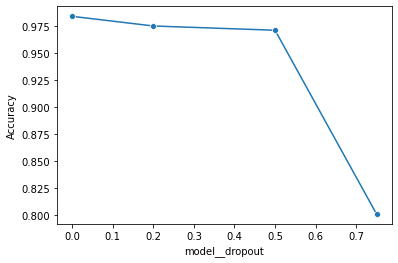

In [147]:
# 
util.plot_grid_search(grid_search2)

# Now we will Run Experiments with Other Model Types

The simpler estimators we will be using will need to make use of the data in a 2D format and can't handle the reshaped data.

In [54]:
# Split x and y to training and remaining dataset
X_train_unshaped, X_rem_unshaped, y_train_unshaped, y_rem_unshaped = train_test_split(X, y, train_size=0.8, random_state = 11292022)
# Split the remainder into test and validation
X_val_unshaped, X_test_unshaped, y_val_unshaped, y_test_unshaped = train_test_split(X_rem_unshaped, y_rem_unshaped, test_size=0.5, random_state = 11292022)
# 80% train, 10% test, 10% validation split

In [55]:
# This will store the results from different models
resultsAccuracy = []

In [91]:
names = ['LR', 'RF', 'Knn', 'SVC', 'DT', 'NN', 'CNN']

# Logistic Regression

In [57]:
from sklearn.linear_model import LogisticRegression

In [58]:
# We have to up the max iterations since the defaut of 100 was far too few
logisticRegressionModel = LogisticRegression(max_iter=10000)

In [59]:
logisticRegressionModel.fit(X_train_unshaped, y_train_unshaped)

LogisticRegression(max_iter=10000)

In [60]:
print("Test Acc Score: ",util.compute_accuracy_binary_class(logisticRegressionModel, X_test_unshaped, y_test_unshaped))
resultsAccuracy.append(util.compute_accuracy_binary_class(logisticRegressionModel, X_test_unshaped, y_test_unshaped))

Test Acc Score:  0.87


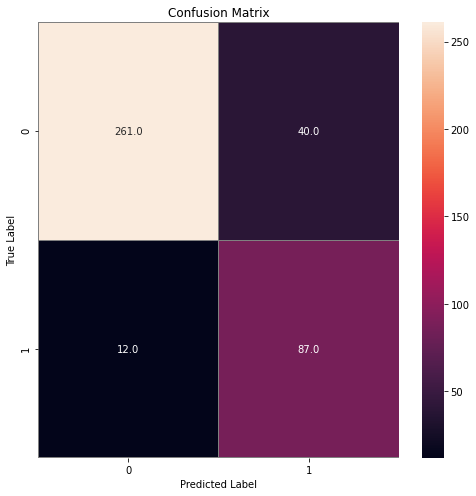

In [64]:
# Now lets take a look at the confusion matrix for the LR Model
util.plot_confusion_binary_class(logisticRegressionModel, X_test_unshaped, y_test_unshaped)

# RandomForestClassifier

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [66]:
randomForestModel = RandomForestClassifier()

In [67]:
randomForestModel.fit(X_train_unshaped, y_train_unshaped)

RandomForestClassifier()

In [68]:
print("Test Acc Score: ",util.compute_accuracy_binary_class(randomForestModel, X_test_unshaped, y_test_unshaped))
resultsAccuracy.append(util.compute_accuracy_binary_class(randomForestModel, X_test_unshaped, y_test_unshaped))

Test Acc Score:  0.955


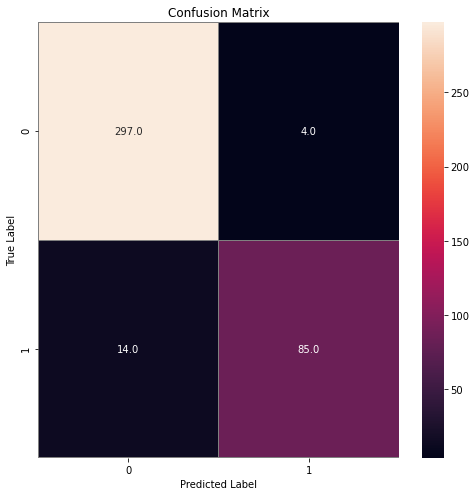

In [69]:
# Now lets take a look at the confusion matrix for the RF Model
util.plot_confusion_binary_class(randomForestModel, X_test_unshaped, y_test_unshaped)

# KNeighborsClassifier

In [70]:
from sklearn.neighbors import KNeighborsClassifier

In [71]:
kNeighborsModel = KNeighborsClassifier()

In [72]:
kNeighborsModel.fit(X_train_unshaped, y_train_unshaped)

KNeighborsClassifier()

In [73]:
print("Test Acc Score: ",util.compute_accuracy_binary_class(kNeighborsModel, X_test_unshaped, y_test_unshaped))
resultsAccuracy.append(util.compute_accuracy_binary_class(kNeighborsModel, X_test_unshaped, y_test_unshaped))

Test Acc Score:  0.9175


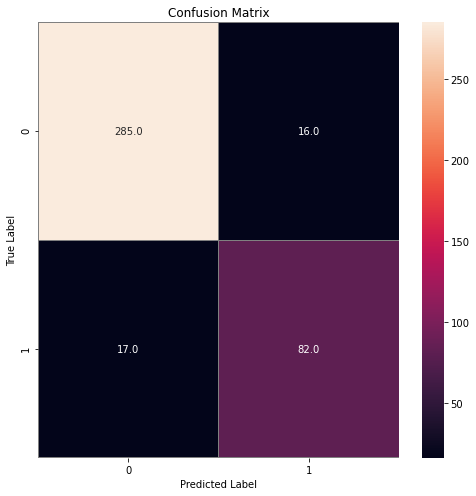

In [74]:
# Now lets take a look at the confusion matrix for the KN Model
util.plot_confusion_binary_class(kNeighborsModel, X_test_unshaped, y_test_unshaped)

# SVC

In [76]:
from sklearn.svm import SVC

In [77]:
svcModel = SVC()

In [78]:
svcModel.fit(X_train_unshaped, y_train_unshaped)

SVC()

In [79]:
print("Test Acc Score: ",util.compute_accuracy_binary_class(svcModel, X_test_unshaped, y_test_unshaped))
resultsAccuracy.append(util.compute_accuracy_binary_class(svcModel, X_test_unshaped, y_test_unshaped))

Test Acc Score:  0.9575


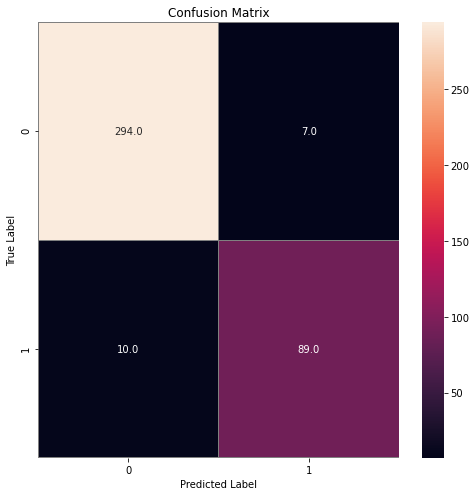

In [80]:
# Now lets take a look at the confusion matrix for the KN Model
util.plot_confusion_binary_class(svcModel, X_test_unshaped, y_test_unshaped)

# Decision Tree Classifier

In [81]:
from sklearn.tree import DecisionTreeClassifier

In [82]:
decisionTreeClassifier = DecisionTreeClassifier()

In [83]:
decisionTreeClassifier.fit(X_train_unshaped, y_train_unshaped)

DecisionTreeClassifier()

In [84]:
print("Test Acc Score: ",util.compute_accuracy_binary_class(decisionTreeClassifier, X_test_unshaped, y_test_unshaped))
resultsAccuracy.append(util.compute_accuracy_binary_class(decisionTreeClassifier, X_test_unshaped, y_test_unshaped))

Test Acc Score:  0.8975


# Plot Model Accuracies

Let's add in the scores for the CNN and NN

In [87]:
resultsAccuracy.append(util.compute_accuracy(model, X_test, y_test))
resultsAccuracy.append(util.compute_accuracy(CNNModel, X_test, y_test))

13/13 [==============================] - 0s 15ms/step


<BarContainer object of 7 artists>

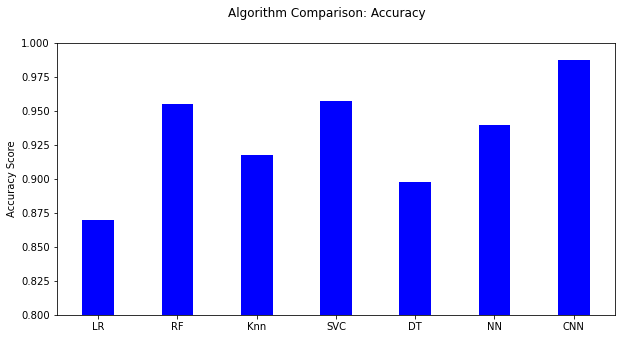

In [92]:
fig = plt.figure(figsize = (10, 5))
fig.suptitle('Algorithm Comparison: Accuracy')
plt.ylabel('Accuracy Score')
plt.ylim(0.8, 1.0)
# creating the bar plot
plt.bar(names, resultsAccuracy, color ='Blue',
        width = 0.4)

It would appear that some models perform quite well, even when compared to the convolutionall neural network which specializes in computer vision/ image recognition tasks. In particular the Random Forest and Support Vector Classifier perform very well reaching an accuracy score of 95% on test data.

Some of the simpler models like Logistic Regression, K-Nearest Neighbors, and Decision Tree fall short of the Neural Networks and the SVC or RF models.

The results of these tests show the merits of a CNN and its ability to differentiate itself even in a relatively simple image classification problem